In [5]:
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
import random
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

%matplotlib inline

from PIL import Image

In [124]:
class brushstroke:
    def __init__(self, canvas, model):
        self.origin = [random.randint(0, canvas.shape[0]), random.randint(0, canvas.shape[0])]
        self.pixels = [self.origin]
        self.model  = model
        self.radius = 5
        self.color  = np.array([0, 0, 0])
        print(self.pixels)
        
    def populate(self, canvas):
        
        copy_canvas = canvas
        
        for p in self.pixels:
            if not np.array_equal(copy_canvas[p[0], p[1]], self.color):
                for i in range(copy_canvas.shape[0]):
                    for j in range(copy_canvas.shape[1]):
                        distance_squared = np.sum(np.square(p-np.array([i,j])))
                        if distance_squared < self.radius**2:
                            copy_canvas[i,j] = self.color
                        
        return copy_canvas
    
    def add(self, pixel):
        self.pixels.append(pixel)
        
    def remove_last(self):
        self.pixels = self.pixels[:-1]
        
    def add_best_pixel(self, canvas):
        
        base_val = get_label_value(canvas, desired_label, self.model)
        #print("base val: {}".format(base_val))
        
        pixel = self.pixels[-1]
        
        best = ""

        try:
            self.add([pixel[0]-1, pixel[1]])
            val = get_label_value(self.populate(canvas), desired_label, self.model)
            if val>base_val:
                base_val = val
                best = "w"
            #print("w val: {}".format(val))

            self.remove_last()
        except IndexError:
            pass

        try:
            self.add([pixel[0]+1, pixel[1]])
            val = get_label_value(self.populate(canvas), desired_label, self.model)
            if val>base_val:
                base_val = val
                best = "e"
            #print("e val: {}".format(val))

            self.remove_last()
        except IndexError:
            pass

        try:
            self.add([pixel[0], pixel[1]-1])
            val = get_label_value(self.populate(canvas), desired_label, self.model)
            if val>base_val:
                base_val = val
                best = "n"
            #print("n val: {}".format(val))

            self.remove_last()
        except IndexError:
            pass

        try:
            self.add([pixel[0], pixel[1]+1])
            val = get_label_value(self.populate(canvas), desired_label, self.model)
            if val>base_val:
                base_val = val
                best = "s"
            #print("s val: {}".format(val))

            self.remove_last()
        except IndexError:
            pass
        
        if best == "":
            r = random.randint(0,3)
            if r == 0:
                best = "w"
            elif r == 1:
                best = "e"
            elif r == 2:
                best = "n"
            elif r == 3:
                best = "s"
        
        if best == "w":
            self.add([pixel[0]-1, pixel[1]])
        elif best == "e":
            self.add([pixel[0]+1, pixel[1]])
        elif best == "n":
            self.add([pixel[0], pixel[1]-1])
        elif best == "s":
            self.add([pixel[0], pixel[1]+1])
            
        #print(self.pixels)
        return self.populate(canvas)
    

In [107]:
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')

#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

In [72]:
def predict(image, model=vgg_model):
    
    if model.name == "resnet50" or model.name == "mobilenet_1.00_224":
        # prepare the image for the VGG model
        processed_image = image.copy()

    elif model.name == "vgg16":
        
        # prepare the image for the VGG model
        processed_image = vgg16.preprocess_input(image.copy())
        #processed_image = image_batch.copy()

    # get the predicted probabilities for each class
    predictions = model.predict(image)
    # print predictions
    
    labels = decode_predictions(predictions, top=-1)
    
    return labels

def get_label_value(canvas, desired_label, model=vgg_model):

        labels = predict(np.expand_dims(canvas, axis=0))

        labels_array = np.array(labels[0])[:,1:]
        labels_dic   = dict(zip(labels_array[:,0], labels_array[:,1]))
        label        = labels_dic[desired_label]
        
        return label

In [67]:
desired_label = "scorpion"

In [28]:
model = vgg_model

In [23]:
load_from_file  = False

In [24]:
x,y = 224,224

In [25]:
if load_from_file:
    filename    = 'media/img0.png'
    original    = load_img(filename, target_size=(x, y))
    numpy_image = img_to_array(original)
    end_image   = np.expand_dims(numpy_image, 0)

In [26]:
canvas = np.ones((x,y,3))*255

In [ ]:
%%time
canvas = np.ones((x,y,3))*255
stroke = brushstroke(canvas, model)

for i in range(100):
    print("{}:\t{}".format(i, get_label_value(canvas, desired_label, model)))
    canvas = stroke.add_best_pixel(canvas)

In [128]:
end_image = np.expand_dims(canvas,0)

In [129]:
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
labels = predict(end_image, model)

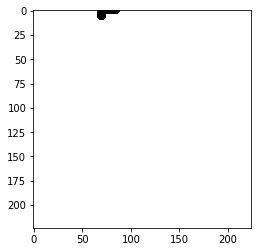

In [130]:
plt.imshow(np.uint8(end_image[0]))

In [68]:
labels_array = np.array(labels[0])[:,1:]
labels_dic   = dict(zip(labels_array[:,0], labels_array[:,1]))
labels_dic[desired_label]

'0.00018293572'